# CKA similarity between layers of a transformer

In [1]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader

In [2]:
class CKAGatherer: 
    """
    This class is an iterator that takes in two dataloaders and the corresponding models. at each iteration it yields 
    a tuple of return objects from the two models.
    """
    def __init__(
            self, 
            model1: nn.Module,
            model2: nn.Module,
            dataloader1: DataLoader,
            dataloader2: DataLoader = None,
            device: str = 'cpu', 
            model1_mode: bool = 'hf', 
            model2_mode: bool = 'hf',
            ):
        """
        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param dataloader1: (DataLoader) Dataloader for model 1
        :param dataloader2: (DataLoader) Dataloader for model 2. If not given, dataloader1 will be used for both models.
        :param device: Device to run the model
        """
        self.model1 = model1
        self.model2 = model2
        self.model1_mode = model1_mode
        self.model2_mode = model2_mode
        self.device = device

        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

        self.dataloader1 = dataloader1
        self.dataloader2 = dataloader2 if dataloader2 is not None else dataloader1

        self.iterator1 = iter(self.dataloader1)
        self.iterator2 = iter(self.dataloader2)

    def __iter__(self):
        return self

    def next_hf(self, model, iterator): 
        input_dict = next(iterator)
        input_ids, attention_mask = input_dict['input_ids'], input_dict['attention_mask']
        # Initialize decoder_input_ids to the pad token
        decoder_input_ids = torch.full((input_ids.shape[0], 1), model.config.pad_token_id, dtype=torch.long)
        return model(input_ids.to(self.device), attention_mask.to(self.device), decoder_input_ids=decoder_input_ids.to(self.device))
    
    def next(self, model, iterator, model_mode): 
        if model_mode == 'hf': 
            return self.next_hf(model, iterator)
        else: 
            return model(next(iterator).to(self.device))

    def __next__(self):
        res1 = self.next(self.model1, self.iterator1, self.model1_mode)
        res2 = self.next(self.model2, self.iterator2, self.model2_mode)
        return res1, res2


In [3]:
from tqdm import tqdm
from functools import partial
from warnings import warn
from typing import List, Dict
import matplotlib.pyplot as plt
from torch_cka.utils import add_colorbar


class CKA:
    def __init__(self,
                 model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """

        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2

        self.device = device

        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):

        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:

                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.

        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        return (1 / (N * (N - 3)) * result).item()

    def compare(
            self,
            dataloader1: DataLoader,
            dataloader2: DataLoader = None, 
        ) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers) if self.model1_layers is not None else len(list(self.model1.modules()))
        M = len(self.model2_layers) if self.model2_layers is not None else len(list(self.model2.modules()))

        self.hsic_matrix = torch.zeros(N, M, 3)

        num_batches = min(len(dataloader1), len(dataloader1))

        gatherer = CKAGatherer(self.model1, self.model2, dataloader1, dataloader2, self.device)
        for _ in tqdm(gatherer, desc="| Comparing features |", total=num_batches):
            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0)
                    assert K.shape == L.shape, f"Feature shape mistach! {K.shape}, {L.shape}"

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches

        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() *
                                                        self.hsic_matrix[:, :, 2].sqrt())

        assert not torch.isnan(self.hsic_matrix).any(), "HSIC computation resulted in NANs"

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset'],

        }

    def plot_results(self,
                     save_path: str = None,
                     title: str = None):
        fig, ax = plt.subplots()
        im = ax.imshow(self.hsic_matrix, origin='lower', cmap='magma')
        ax.set_xlabel(f"Layers {self.model2_info['Name']}", fontsize=15)
        ax.set_ylabel(f"Layers {self.model1_info['Name']}", fontsize=15)

        if title is not None:
            ax.set_title(f"{title}", fontsize=18)
        else:
            ax.set_title(f"{self.model1_info['Name']} vs {self.model2_info['Name']}", fontsize=18)

        add_colorbar(im)
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, dpi=300)

        plt.show()

In [48]:
import re  
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset

In [49]:
def clear_hooks(model):
    for module in model.modules():
        module._forward_hooks.clear()
        module._backward_hooks.clear()
        module._forward_pre_hooks.clear()

In [50]:
# Load in T5 small 
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [51]:
# Load in the GLUE data
dataset = load_dataset('glue', 'mrpc')

# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['sentence1'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Reusing dataset glue (/home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 255.82it/s]
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c4bf414fff471189.arrow
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-785eb0bcb4839f23.arrow
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-42cd2687f56420a6.arrow


In [52]:
# Convert the dataset into a PyTorch DataLoader.
def hf_dataset_to_dataloader(dataset, batch_size=64, drop_last=True):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, 
        drop_last=drop_last
    )
    return dataloader, len(dataset) // batch_size + (not drop_last)

dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'], batch_size=4)

In [53]:
gatherer = CKAGatherer(model, model, dataloader, device='cpu')

In [55]:
for r1, r2 in tqdm(gatherer, total=num_batches):
    pass

  0%|          | 1/431 [00:07<52:27,  7.32s/it]

: 

In [54]:
gatherer.next_hf(model, iter(dataloader))

Seq2SeqLMOutput(loss=None, logits=tensor([[[-18.7648, -10.2408, -13.8692,  ..., -42.8127, -42.7781, -42.6568]],

        [[-25.5117, -13.0997, -19.1239,  ..., -50.9011, -50.8470, -50.7570]],

        [[-21.3258, -10.3775, -15.9447,  ..., -50.5777, -50.5608, -50.4276]],

        [[-32.4413, -14.3859, -24.4555,  ..., -61.7149, -61.7652, -61.6407]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.4865, -2.3323, -1.1428,  ..., -2.5693, -1.7539, -0.5693]],

         [[-0.9565, -2.3581, -0.2478,  ...,  1.1193,  0.7770,  0.5377]],

         [[ 1.0704, -2.5709,  0.6892,  ..., -1.3349,  0.2768,  0.5756]],

         ...,

         [[-0.6660,  2.2657,  0.3124,  ...,  1.4158, -2.9123, -1.1275]],

         [[-6.0374, -1.1453, -1.5700,  ..., -1.3067, -0.1885,  1.6042]],

         [[ 0.0485, -0.0356, -0.0691,  ...,  0.6128, -0.2485, -0.2954]]],


        [[[-0.4865, -2.3323, -1.1428,  ..., -2.5693, -1.7539, -0.5693]],

         [[-0.9565, -2.3581, -0.2478,  ...,  1.1193,  0.77

In [14]:
def match_module_names_from_pattern(model: nn.Module, pattern: re.Pattern | str) -> list[str]:
    if isinstance(pattern, str): 
        pattern = re.compile(pattern)
    return [name for name, _ in model.named_modules() if pattern.match(name)]


def match_module_names(model: nn.Module, *patterns: re.Pattern | str) -> list[str]: 
    if len(patterns) == 1: 
        pattern = patterns[0]
    elif len(patterns) > 1:
        pattern = re.compile('|'.join([p.pattern if isinstance(re.Pattern, p) else p for p in patterns]))
    return match_module_names_from_pattern(model, pattern)

In [15]:
pattern_q = re.compile(r'block\.\d+\.layer\.\d+\.SelfAttention\.q')
pattern_fc = re.compile(r'block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')
pattern_q_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.SelfAttention\.q')
pattern_k_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.SelfAttention\.k')
pattern_v_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.SelfAttention\.v')
pattern_fc_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')
model_layers = match_module_names(model, pattern_fc_model)
model_layers

['encoder.block.0.layer.1.DenseReluDense.wi',
 'encoder.block.0.layer.1.DenseReluDense.wo',
 'encoder.block.1.layer.1.DenseReluDense.wi',
 'encoder.block.1.layer.1.DenseReluDense.wo',
 'encoder.block.2.layer.1.DenseReluDense.wi',
 'encoder.block.2.layer.1.DenseReluDense.wo',
 'encoder.block.3.layer.1.DenseReluDense.wi',
 'encoder.block.3.layer.1.DenseReluDense.wo',
 'encoder.block.4.layer.1.DenseReluDense.wi',
 'encoder.block.4.layer.1.DenseReluDense.wo',
 'encoder.block.5.layer.1.DenseReluDense.wi',
 'encoder.block.5.layer.1.DenseReluDense.wo']

In [67]:

CKA(model, model, model1_layers=model_layers, model2_layers=model_layers).compare(dataloader, dataloader, 2, num_batches)

/tmp/ipykernel_179838/3057297227.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |:   0%|          | 0/16 [00:00<?, ?it/s]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:   6%|▋         | 1/16 [00:02<00:33,  2.21s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  12%|█▎        | 2/16 [00:04<00:29,  2.08s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  19%|█▉        | 3/16 [00:06<00:27,  2.09s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  25%|██▌       | 4/16 [00:08<00:25,  2.11s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  31%|███▏      | 5/16 [00:10<00:23,  2.13s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  38%|███▊      | 6/16 [00:12<00:21,  2.15s/it]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |:  38%|███▊      | 6/16 [00:14<00:23,  2.35s/it]


KeyboardInterrupt: 

In [8]:
def run_cka(
    model: torch.nn.Module, 
    dataloader: DataLoader, 
    model_name: str | None = None, 
    model_layers: list[str] | None = None, 
    device: str = 'cpu', 
    max_length: int = 1
) -> CKA: 
    """
    Runs CKA for every pair of layers in the model and plots the results as a heatmap. 
    """
    if model_name is None: 
        model_name = model.__class__.__name__
    cka = CKA(
        model1=model, 
        model2=model,
        model1_name=model_name,
        model2_name=model_name,   
        model1_layers=model_layers,
        model2_layers=model_layers,
        device=device,
    )
    cka.compare(dataloader1=dataloader, dataloader2=dataloader, max_length=max_length)
    cka.plot_results()
    return cka


dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(64)), batch_size=8)

In [64]:
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
run_cka(model, dataloader, model_layers=None, max_length=2)

/tmp/ipykernel_189563/933625643.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
/tmp/ipykernel_189563/933625643.py:62: UserWarning: Model 1 seems to have a lot of layers. Consider giving a list of layers whose features you are concerned with through the 'model1_layers' parameter. Your CPU/GPU will thank you :)
  warn("Model 1 seems to have a lot of layers. " \
/tmp/ipykernel_189563/933625643.py:69: UserWarning: Model 2 seems to have a lot of layers. Consider giving a list of layers whose features you are concerned with through the 'model2_layers' parameter. Your CPU/GPU will thank you :)
  warn("Model 2 seems to have a lot of layers. " \


AttributeError: 'tuple' object has no attribute 'detach'

/tmp/ipykernel_189563/933625643.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \


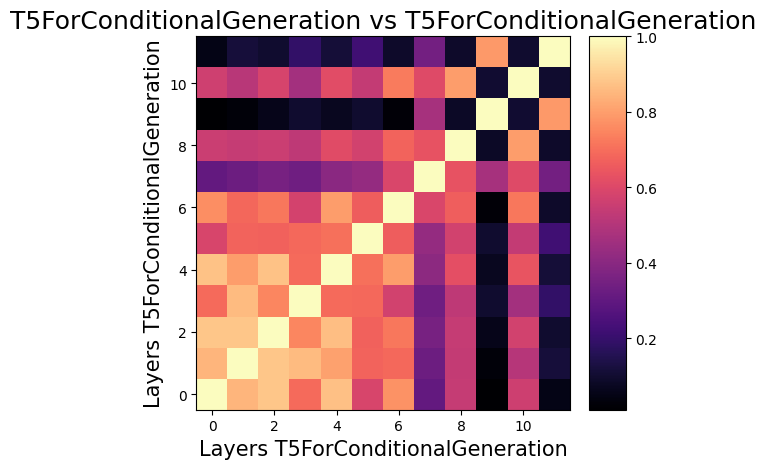

In [60]:
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
run_cka(model, dataloader, model_layers=model_layers, max_length=2)

/tmp/ipykernel_189563/933625643.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \


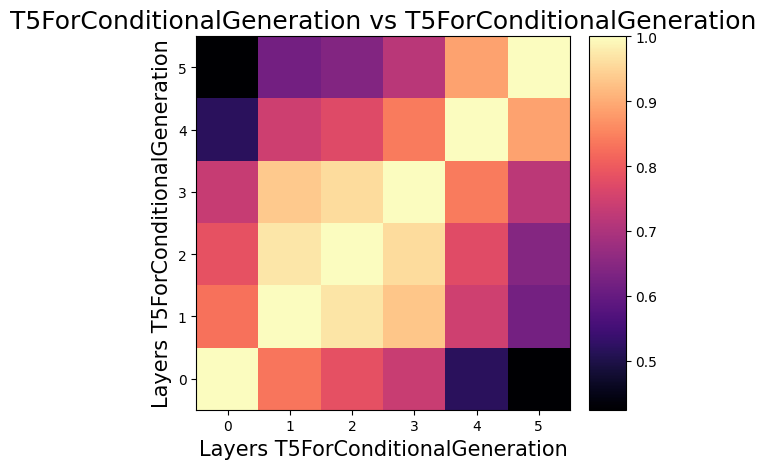

In [61]:
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
run_cka(model, dataloader, model_layers=match_module_names(model, pattern_q_model), max_length=2)

/tmp/ipykernel_189563/933625643.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \


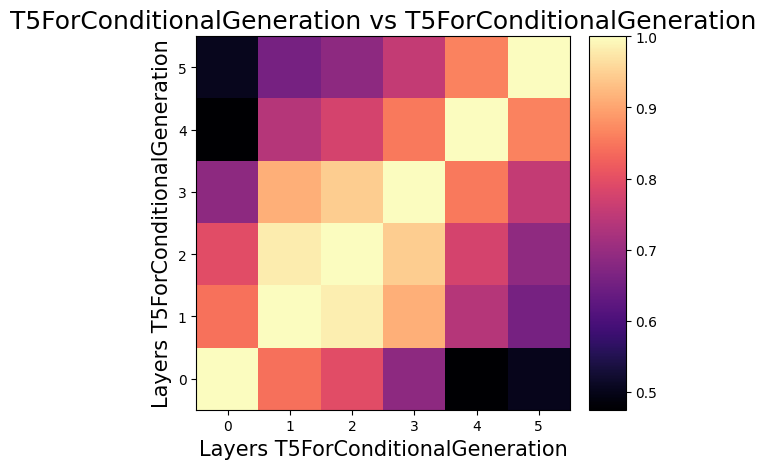

In [62]:
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
run_cka(model, dataloader, model_layers=match_module_names(model, pattern_k_model), max_length=2)

/tmp/ipykernel_189563/933625643.py:51: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \


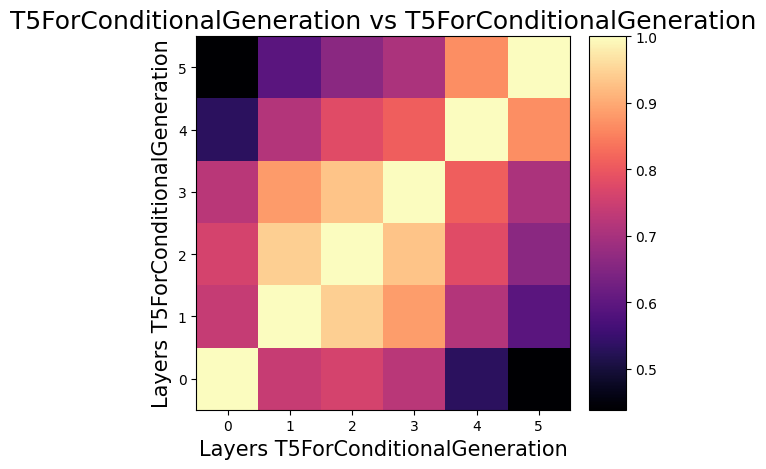

In [63]:
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
run_cka(model, dataloader, model_layers=match_module_names(model, pattern_v_model), max_length=2)

In [38]:
output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
# translate output and input and remove padding tokens
output = tokenizer.batch_decode(output, skip_special_tokens=True)
input_ids = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
input_ids = [re.sub(r'<pad>', '', input_id) for input_id in input_ids]
output = [re.sub(r'<pad>', '', output_) for output_ in output]
# print input and output
for input_id, output_ in zip(input_ids, output): 
    print(f'Input: {input_id}')
    print(f'Output: {output_}')
    print()

Input: PCCW's chief operating officer, Mike Butcher, and Alex Arena, the chief financial officer, will report directly to Mr So.
Output: Mike Butcher, chief operating officer, PCCW's chief operating officer, and Alex Arena, the chief financial officer, will report directly to Mr So.

Input: The world's two largest automakers said their U.S. sales declined more than predicted last month as a late summer sales frenzy caused more of an industry backlash than expected.
Output: 's two largest automakers said their U.S. sales declined more than predicted last month. a late summer sales frenzy caused more of an industry backlash than expected.

Input: According to the federal Centers for Disease Control and Prevention ( news - web sites ), there were 19 reported cases of measles in the United States in 2002.
Output: Selon the federal Centers for Disease Control and Prevention ( news - web sites ), there were 19 reported cases of measles in the United States in 2002.

Input: A tropical storm r

/tmp/ipykernel_189563/1152927856.py:51: UserWarning: Both model have identical names - T5 small. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |:   0%|          | 0/1 [00:00<?, ?it/s]

Input length of decoder_input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
| Comparing features |: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

torch.Size([4, 2])


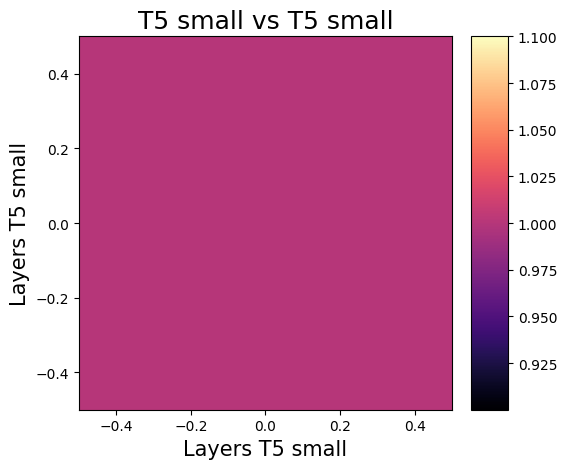

| Comparing features |: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

torch.Size([4, 10])


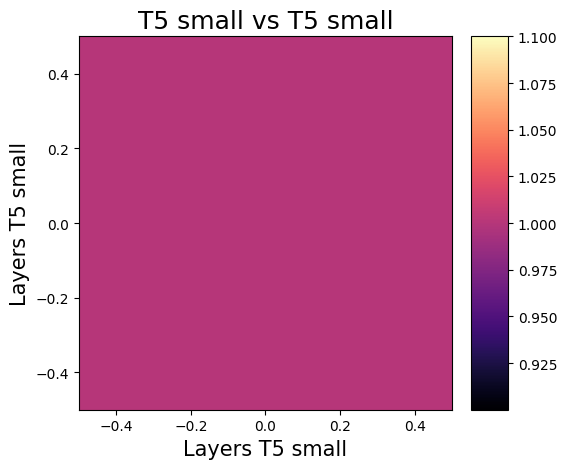

| Comparing features |: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

torch.Size([4, 50])


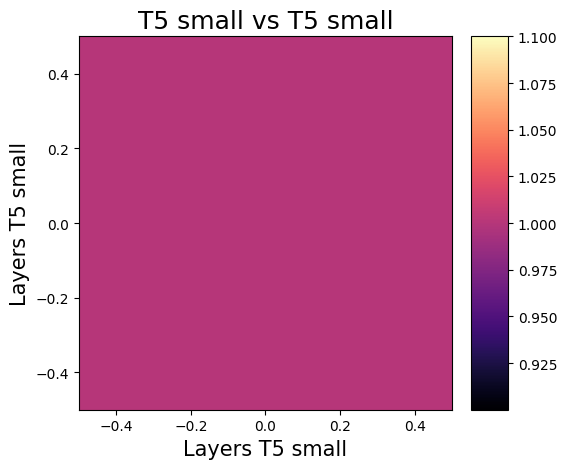

In [22]:
ckas = []
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(4)), batch_size=4)
for max_length in [1, 10, 50]: 
    clear_hooks(model)
    ckas.append(run_cka(model, dataloader, model_name="T5 small", model_layers=[model_layers[0]], max_length=max_length))

In [26]:
ckas[1].model1_features['encoder.block.0.layer.1.DenseReluDense.wi'].allclose(ckas[0].model1_features['encoder.block.0.layer.1.DenseReluDense.wi'])

True

In [11]:
ckas[1].model1_features['encoder.block.0.layer.1.DenseReluDense.wi'].shape
model.encoder.block[0].layer[1].DenseReluDense.wi.register_forward_pre_hook(lambda module, input: print(input[0].shape))

In [103]:
ckas[2].model1_features['encoder.block.0.layer.1.DenseReluDense.wi'].shape

torch.Size([4, 2048])

In [12]:
for input_dict in dataloader: 
    input_ids, attention_mask = input_dict['input_ids'], input_dict['attention_mask']
    break 

In [35]:
# Register prehook that tells the input shape 
clear_hooks(model)
foo = []
# Add a hook that takes the output of the 'encoder.block.0.layer.1.DenseReluDense.wi' layer and adds its [0, 0] element to foo 
model.encoder.block[0].layer[1].DenseReluDense.wi.register_forward_hook(lambda module, input, output: foo.append(output[0, 0, 0]))


model.generate(input_ids=input_ids, attention_mask=attention_mask, min_length=10, max_length=10)

tensor([[    0,  4794,   299,  1703,     6,  5752,  2699,  5502,     3,     6],
        [    0, 32099,     3,    31,     7,   192,  2015,  1510,  8910,   243],
        [    0,     3, 17152,     8,  2822,  1166,     7,    21, 14326,  4330],
        [    0, 32099,  1771,    11,    47,  1644,    12,  1560,  5775,   590]])

In [36]:
foo

[tensor(-4.9401)]